In [1]:
require(FNN)
require(data.table)

Loading required package: FNN
Loading required package: data.table


In [2]:
filelist = list.files('./data/dynverse_data_v2/',pattern='*.expression$',full.names = T,recursive = T)
fileanno = gsub('expression','anno',filelist,fixed=T)

In [ ]:
#To load precomputed benchmark results,
#you may uncomment the next line and skip the next cell
#plotdata=fread('./graphdrdr.perf.txt')

In [4]:
allacc= c()
alldim= c()
allmethod = c()
allfiles=c()
allcors=c()
for (i in 1:339){
  print(i)
  set.seed(100)
  anno=read.csv(as.character(fileanno[i]),sep='\t',header=T)
  datapca=read.table(paste0(filelist[i],'.pca20'),sep='\t',row.names=NULL)[,-1][,1:20]
  subinds = sample(dim(datapca)[1],size = min(1000,dim(datapca)[1]),replace = F)
  data.dist0 = dist(datapca[subinds,1:20])
  for (m in c('.graphdr20',
              '.pca20','.phate20','.tsne2','.umap2','.umap20','.diffmap20')){
        print(filelist[i])
        dr=read.table(paste0(filelist[i],gsub('.graphdr20', '.dim20_k10_reg50_n0t12_pca.graphdr',m)),sep='\t',row.names=NULL)[,-1]
        validind = anno[,2]!=''
        for (j in 2:min(dim(dr)[2],20)){
          print(j)
          allfiles=c(allfiles,as.character(fileanno[i]))
          allacc= c(allacc, mean(as.character(knn.cv(dr[validind,1:j],anno[validind,2]))==as.character(anno[validind,2])))
          alldim = c(alldim, j)
          allmethod = c(allmethod,m)
          dr.dist = dist(as.matrix(dr[subinds,1:j]))
          allcors = c(allcors, cor(as.numeric(data.dist0),as.numeric(dr.dist)))

        }
    }
}
plotdata = data.table(file=allfiles, accuracy=allacc,dim=alldim, cor = allcors,method = allmethod)



Loading required package: ggplot2


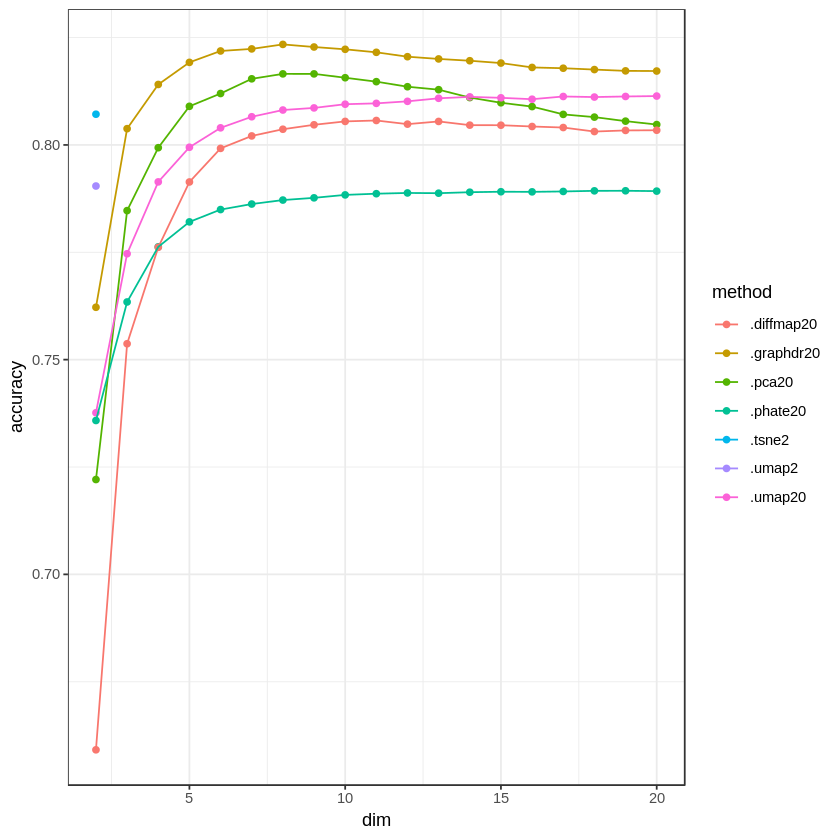

In [5]:
require(ggplot2)

ggplot(plotdata[  ,.(accuracy=mean(accuracy)),by=c('method','dim')])+geom_point(aes(x=dim,y=accuracy,color=method),alpha=I(0.99))+
geom_line(aes(x=dim,y=accuracy,color=method))+theme_bw()
ggsave('./figures/dynbenchmark.drgraph_comparison.1.all.pdf',width = 5.5,height = 4)


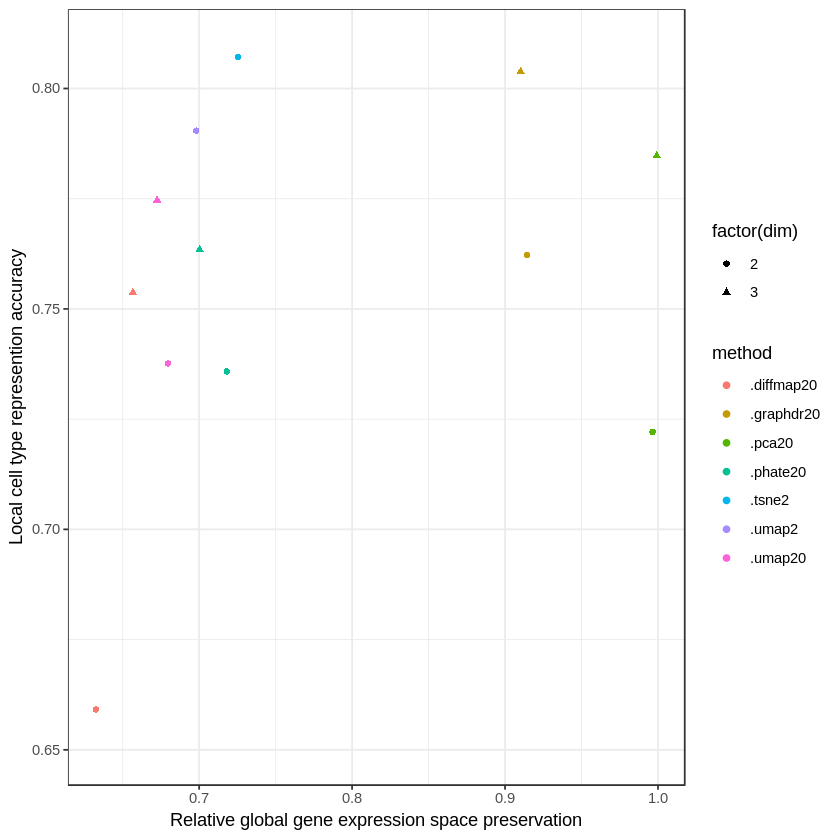

In [6]:
plotdata[,cor_scaled := cor/max(cor),by=.(dim,file)]
ggplot()+geom_point(aes(x=cor,y=accuracy,color=method, shape=factor(dim)),alpha=I(0.99), 
                    data=plotdata[dim %in% c(2,3) ,.(cor=mean(cor_scaled),accuracy=mean(accuracy)),by=list(method,dim)])+
scale_y_continuous(limits = c(0.65,0.81))+
  xlab('Relative global gene expression space preservation')+
  ylab('Local cell type represention accuracy')+theme_bw()
ggsave('./figures/dynbenchmark.drgraph_comparison.2d.all.pdf',width = 5.5,height = 4)
